In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from imblearn.over_sampling import SMOTE

In [2]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()

In [3]:
df_ori.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,7043.0,3521.000000,2033.283305,0.000000,1760.500000,3521.000000,5281.50000,7042.00000
Tenure Months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.00000,72.00000
Monthly Purchase (Thou. IDR),7043.0,84.190200,39.117061,23.725000,46.150000,91.455000,116.80500,154.37500
Longitude,7043.0,107.043246,0.358316,106.816666,106.816666,106.816666,107.60981,107.60981
Latitude,7043.0,-6.404184,0.322898,-6.914744,-6.914744,-6.200000,-6.20000,-6.20000
CLTV (Predicted Thou. IDR),7043.0,5720.384481,1537.974298,2603.900000,4509.700000,5885.100000,6994.65000,8450.00000


In [4]:
df_ori.describe(exclude="number").T

,count,unique,top,freq
Location,7043,2,Jakarta,5031
Device Class,7043,3,High End,3096
Games Product,7043,3,No,3498
Music Product,7043,3,No,3088
Education Product,7043,3,No,3095
Call Center,7043,2,No,4999
Video Product,7043,3,No,2810
Use MyApp,7043,3,No,2785
Payment Method,7043,4,Pulsa,2365
Churn Label,7043,2,No,5174


# Background

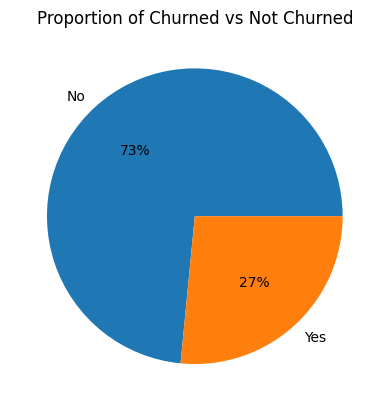

In [5]:
plot_df = df['Churn Label'].value_counts(normalize=True)*100
plt.pie(plot_df, labels=plot_df.index, autopct='%.0f%%')
plt.title("Proportion of Churned vs Not Churned")
plt.show()

27% of passengers churned from purchasing

In [6]:
display(df.groupby("Churn Label")["CLTV (Predicted Thou. IDR)"].sum())
display(df.groupby("Churn Label")["Monthly Purchase (Thou. IDR)"].sum())

Churn Label
No     30206835.1
Yes    10081832.8
Name: CLTV (Predicted Thou. IDR), dtype: float64

Churn Label
No     412081.475
Yes    180870.105
Name: Monthly Purchase (Thou. IDR), dtype: float64

Around `Rp10,081,832,800.00` potential income in the future gone.

Around `Rp180,870,800.00` stripped out from the company's monthly income.

# EDA

## Univariate

### Original

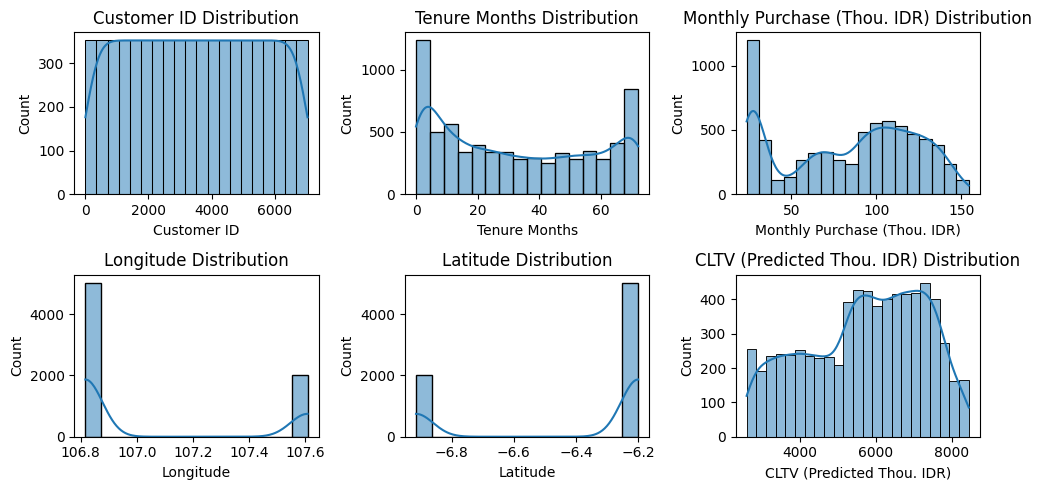

In [7]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(10, 5))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.histplot(data=df, x=numerical_columns[i], kde=True, ax=col)
        col.set_title(f"{numerical_columns[i]} Distribution")
        i+=1
fig.tight_layout()

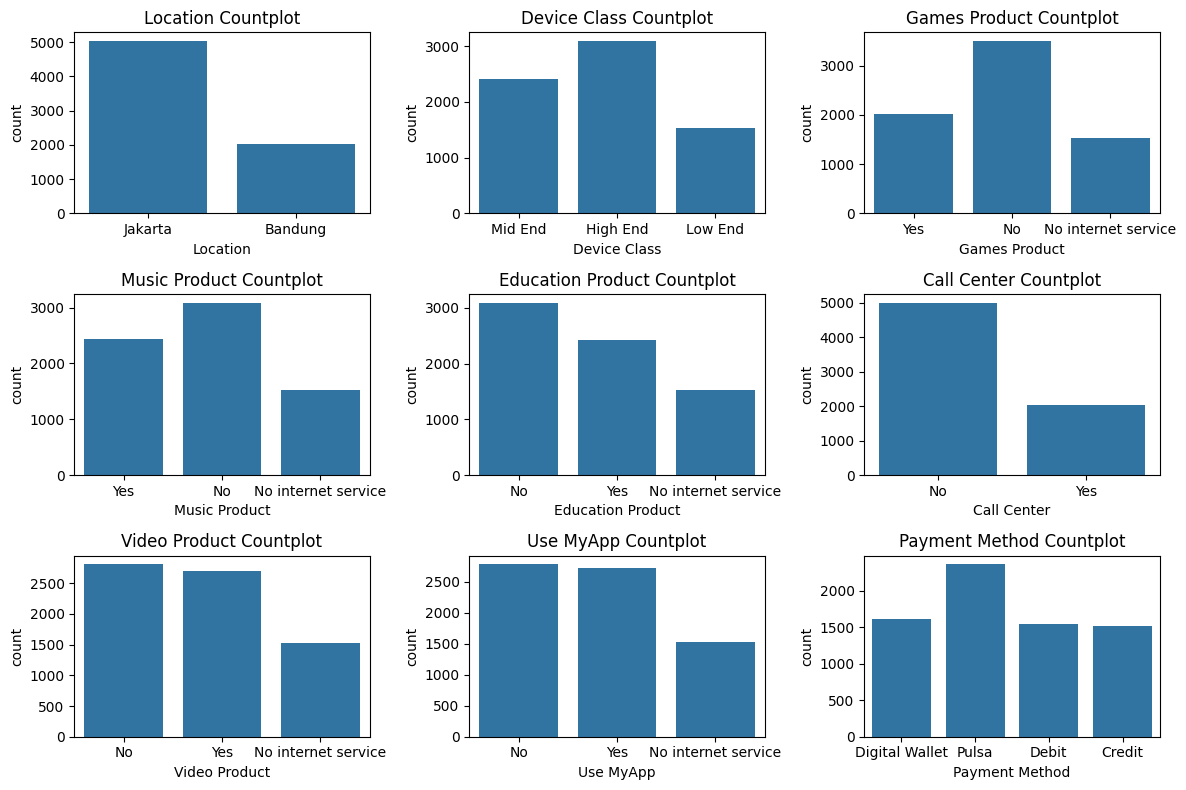

In [8]:
numerical_columns = df.select_dtypes(include=[object]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(12, 8))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.countplot(data=df,x=numerical_columns[i], ax=col)
        col.set_title(f"{numerical_columns[i]} Countplot")
        i+=1
fig.tight_layout()

### Hue `Churn Label`

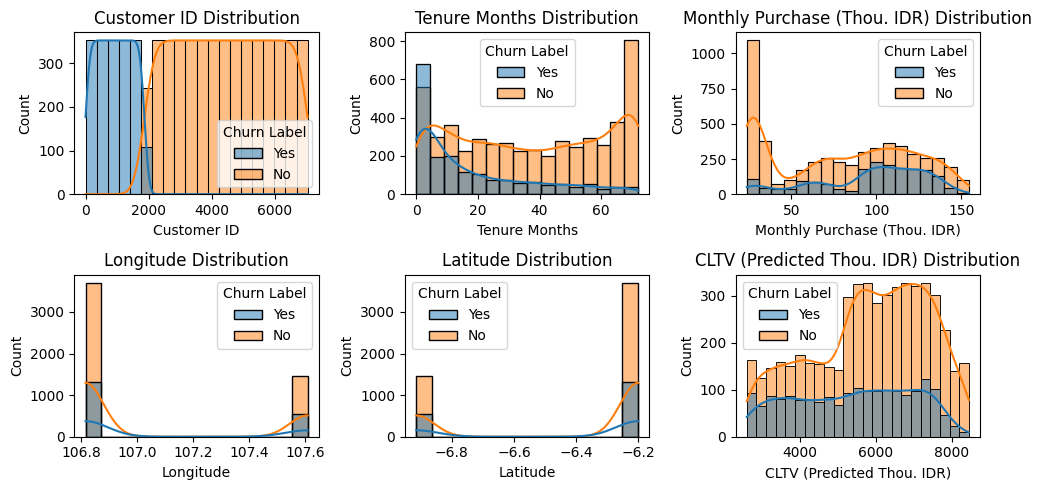

In [9]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(10, 5))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.histplot(data=df, x=numerical_columns[i], hue="Churn Label", kde=True, ax=col)
        col.set_title(f"{numerical_columns[i]} Distribution")
        i+=1
fig.tight_layout()

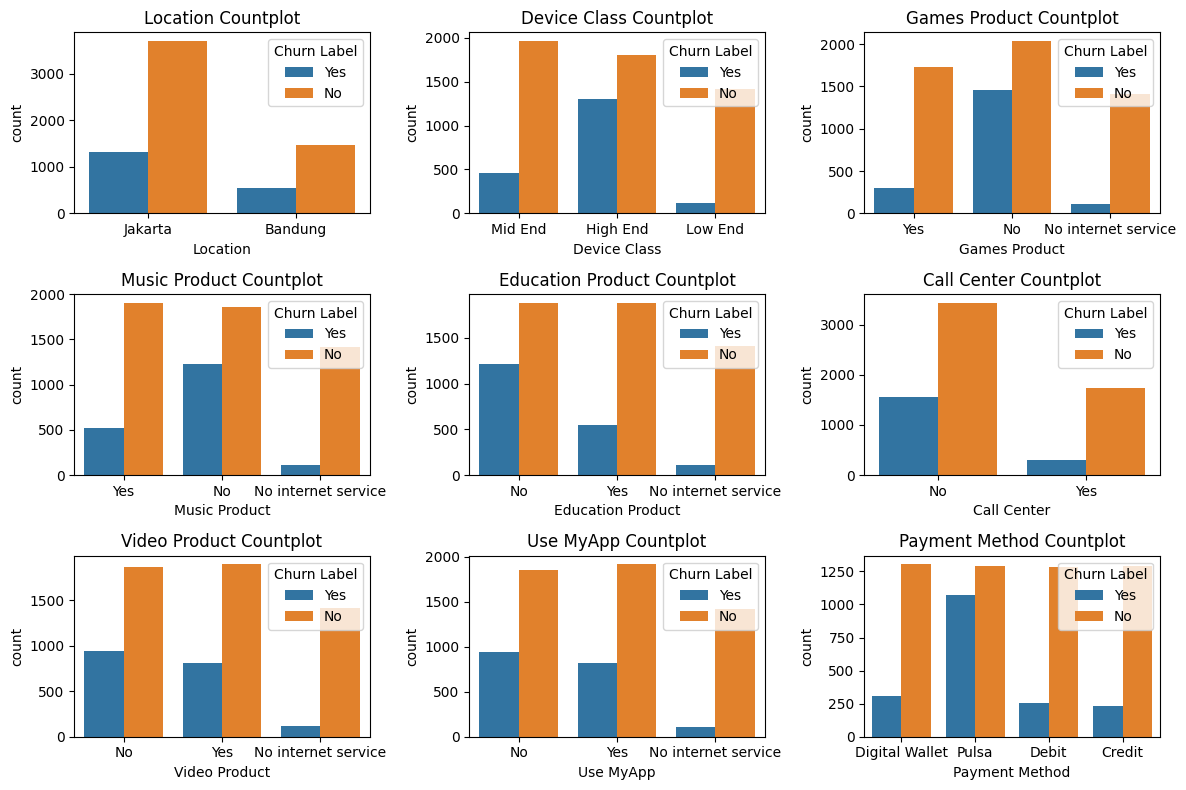

In [10]:
numerical_columns = df.select_dtypes(include=[object]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(12, 8))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.countplot(data=df,x=numerical_columns[i], hue='Churn Label', ax=col)
        col.set_title(f"{numerical_columns[i]} Countplot")
        i+=1
fig.tight_layout()

### Skew

In [11]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
for col in numerical_columns:
    skewness = df[col].skew()
    if skewness < -0.5: 
        print(f"{col}, skewness: {skewness}, left skewed")
    elif skewness > 0.5: 
        print(f"{col}, skewness: {skewness}, right skewed")
    else: 
        print(f"{col}, skewness: {skewness}, approximately symmetric")

Customer ID, skewness: 0.0, approximately symmetric
Tenure Months, skewness: 0.2395397495619829, approximately symmetric
Monthly Purchase (Thou. IDR), skewness: -0.2205244339439807, approximately symmetric
Longitude, skewness: 0.9491054700666193, right skewed
Latitude, skewness: -0.9491054700664001, left skewed
CLTV (Predicted Thou. IDR), skewness: -0.3116021004049805, approximately symmetric


### Kurtosis

In [12]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
for col in numerical_columns:
    kurtosis = df[col].kurtosis()
    if kurtosis > 3:
        print(f"{col}, kurtosis: {kurtosis}, leptokurtic (heavy tailed, more chance of outliers)")
    elif kurtosis < 3:
        print(f"{col}, kurtosis: {kurtosis}, platykurtic")
    else:
        print(f"{col}, kurtosis: {kurtosis}, mesokurtic")

Customer ID, kurtosis: -1.1999999999999997, platykurtic
Tenure Months, kurtosis: -1.3873716359716848, platykurtic
Monthly Purchase (Thou. IDR), kurtosis: -1.2572596945495054, platykurtic
Longitude, kurtosis: -1.099511115413302, platykurtic
Latitude, kurtosis: -1.0995111154135797, platykurtic
CLTV (Predicted Thou. IDR), kurtosis: -0.9340324830072797, platykurtic


## Device Class

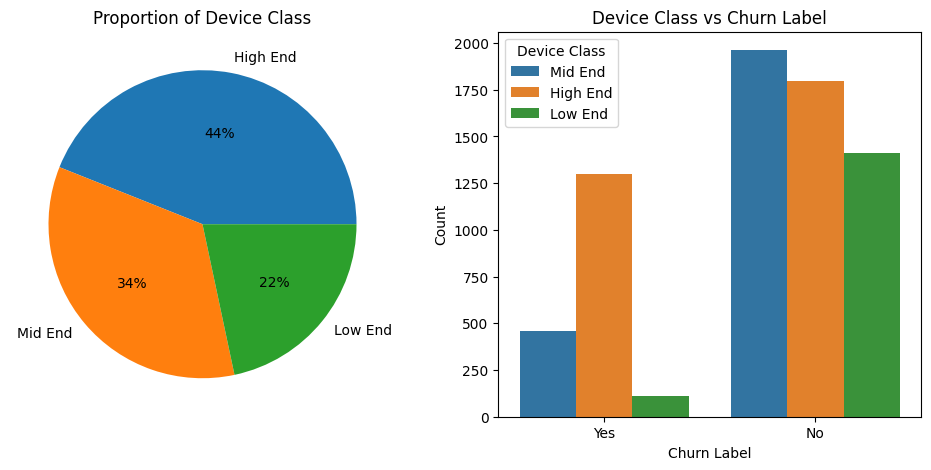

In [13]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Device Class
# =================================================================
plot_df = df["Device Class"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Device Class")

# Device Class vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Device Class', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Device Class vs Churn Label")
plt.show()

1. `~1250` customer who churned are from the high end class followed by mid (`~500`) and low (`~125`) end class. From this data higher end devices resulted in more likely to churn.
2. The proportion is dominated by **High End**, followed by **Mid End** and **Low End**

## Location

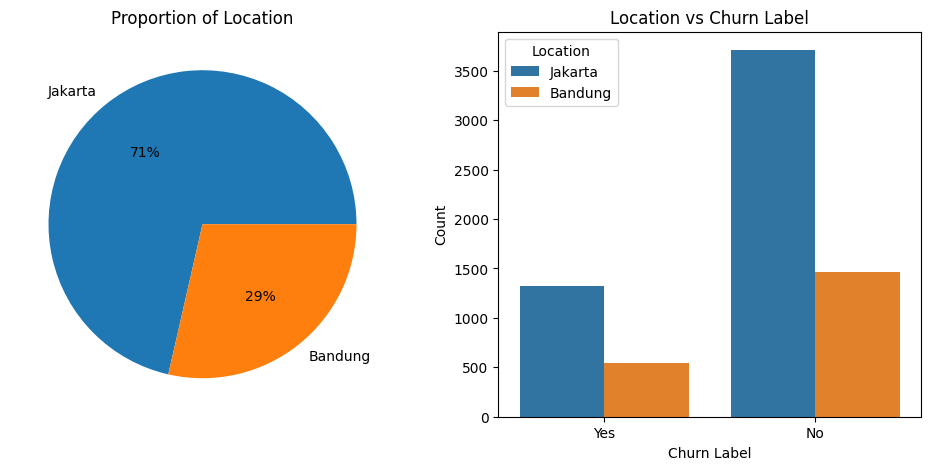

In [14]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Location
# =================================================================
plot_df = df["Location"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Location")

# Location vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Location', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Location vs Churn Label")
plt.show()

In [15]:
location_churn = df.pivot_table(values="Customer ID", index="Churn Label", columns="Location", aggfunc="count", margins=True)
location_churn / location_churn.loc["All", :]

Location,Bandung,Jakarta,All
Churn Label,,,
No,0.728628,0.73703,0.73463
Yes,0.271372,0.26297,0.26537
All,1.000000,1.00000,1.00000


1. Jakarta has the highes churn rate, but It's due to inequality of proportion between users from **Jakarta** and **Bandung**
2. The changes of user either from `Bandung` and `Jakarta` are almost the same. 

## Games Product, Music Product, Education Product, Video Product, and Use MyApp
`No internet service` and `No` means the same thing which is the use doesn't use the internet for the specified **product** or **app**.

In [16]:
# change label of product and app
def preprocess_data(df):
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1
    
    df=df.copy()
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    
    # prod_app_map = {
    #     "Yes": 1,
    #     "No": 0,
    #     "No internet service": 0,
    # }
    # df['Games Product'] = df['Games Product'].replace(prod_app_map)
    # df['Music Product'] = df['Music Product'].replace(prod_app_map)
    # df['Education Product'] = df['Education Product'].replace(prod_app_map)
    # df['Video Product'] = df['Video Product'].replace(prod_app_map)
    # df['Use MyApp'] = df['Use MyApp'].replace(prod_app_map)

    df['Churn'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)    
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    return df

df = preprocess_data(df_ori)

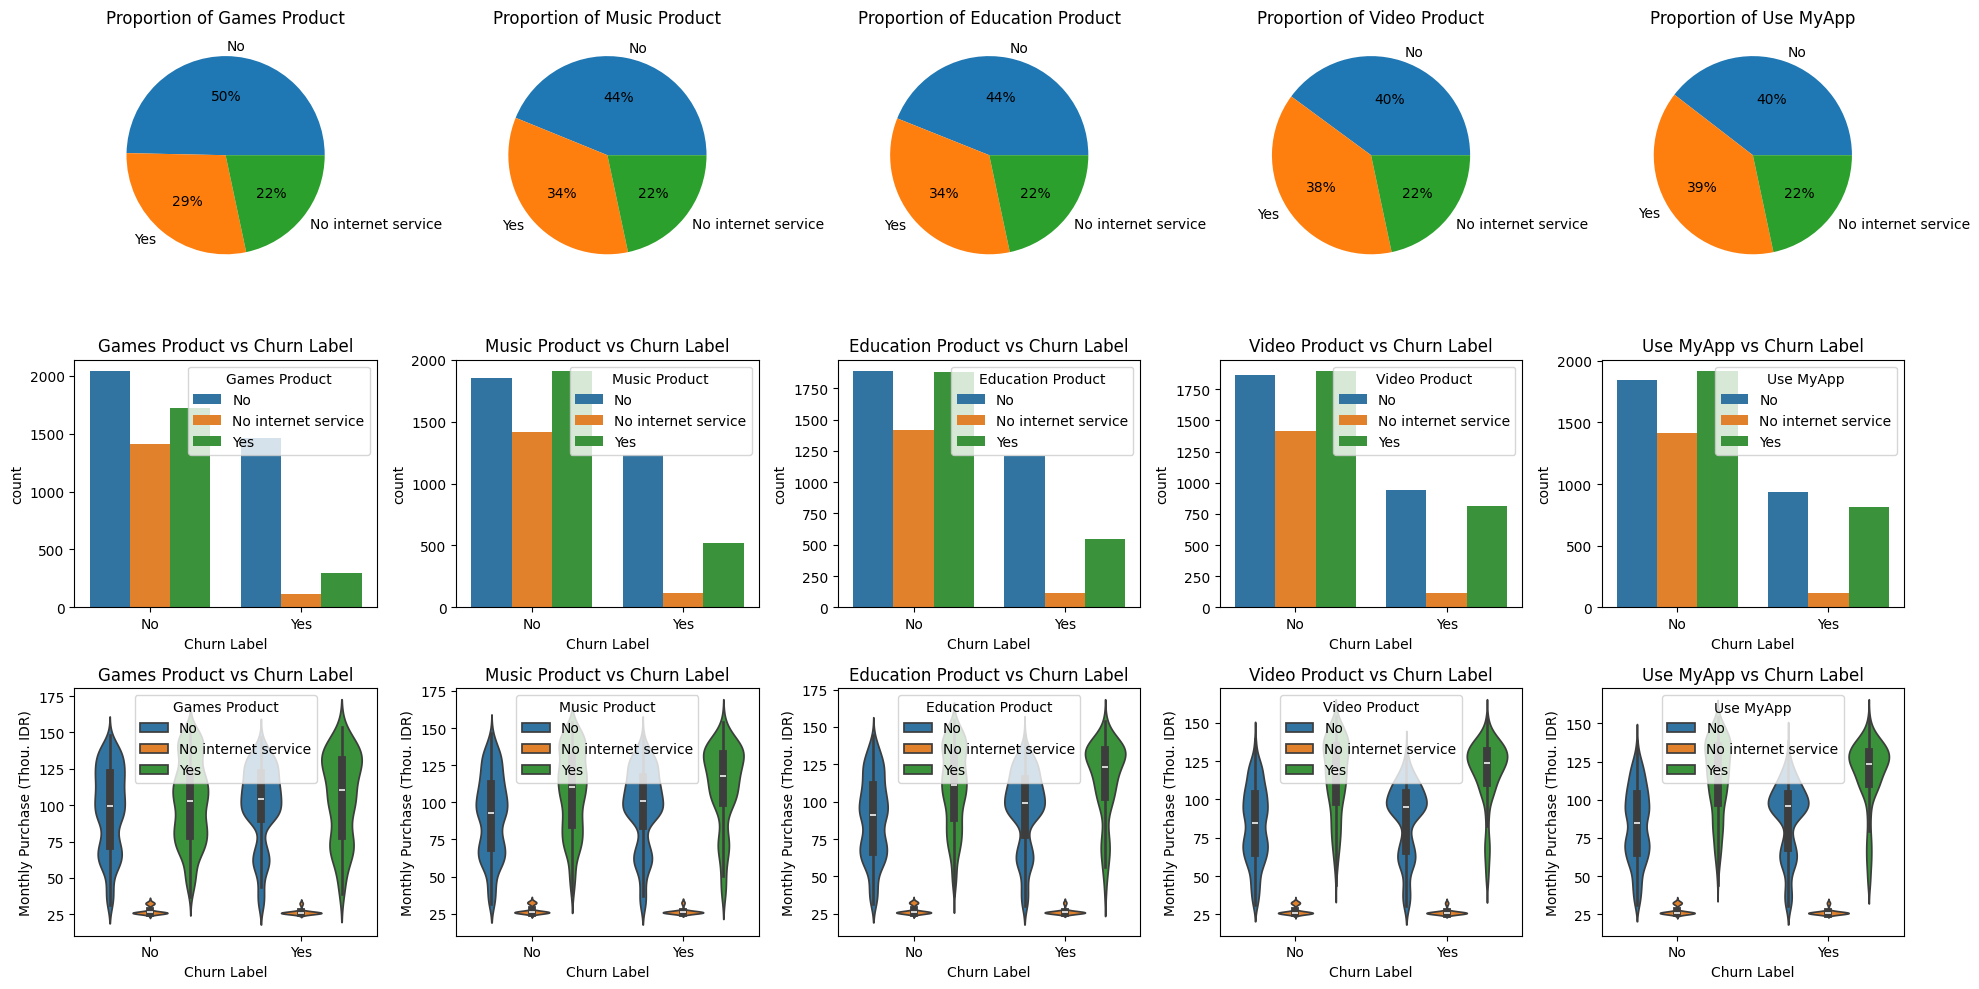

In [17]:

cols = ["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]
fig, ax = plt.subplots(nrows=3, ncols=len(cols), figsize=(20, 10))

for i, c in enumerate(cols):
    plot_df = df[c].value_counts(normalize=True) * 100
    ax[0][i].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
    ax[0][i].set_title(f"Proportion of {c}")
    

for i, c in enumerate(cols):
    sns.countplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', hue=c, ax=ax[1][i])
    ax[1][i].set_title(f"{c} vs Churn Label")
    
    
for i, c in enumerate(cols):
    sns.violinplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', y="Monthly Purchase (Thou. IDR)", hue=c, ax=ax[2][i])
    ax[2][i].set_title(f"{c} vs Churn Label")

fig.tight_layout()

1. People who didn't use internet service for Games, Music, and Education Product has a higher change of churn.
2. People who's monthly purchase is around **100K** and didn't use the internet service for any of the products has more change of churning
3. People who's monthly purchase is around **125K** and didn't use the internet service for any of the products has more change of churning

Users who churned they don't use the internet service for accessing those products

## Payment Method

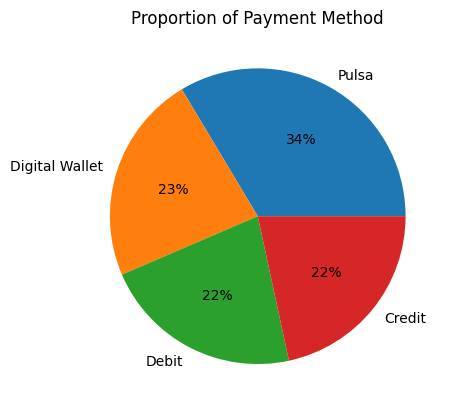

In [18]:
plot_df = df["Payment Method"].value_counts(normalize=True) * 100
plt.pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
plt.title(f"Proportion of Payment Method")
plt.show()

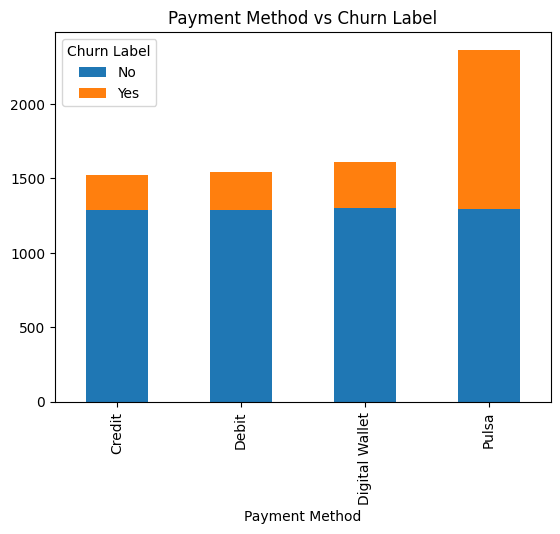

In [19]:
plot_df = df.pivot_table(index="Payment Method", columns="Churn Label", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
plt.title("Payment Method vs Churn Label")
plt.show()

In [20]:
churn_payment_method = df.pivot_table(index="Payment Method", columns="Churn", values="Customer ID", aggfunc="count", margins=True)
churn_payment_method /= churn_payment_method.loc['All', :]
churn_payment_method = churn_payment_method.loc[churn_payment_method.index != 'All', churn_payment_method.columns != 'All']
churn_payment_method

Churn,0,1
Payment Method,,
Credit,0.249324,0.124131
Debit,0.248550,0.138042
Digital Wallet,0.252029,0.164794
Pulsa,0.250097,0.573034


1. Users buy using pulsa has high change of churn

## Tenure Months

In [21]:
df.pivot_table(index="Churn", values="Tenure Months", aggfunc="mean")

,Tenure Months
Churn,
0,37.569965
1,17.979133


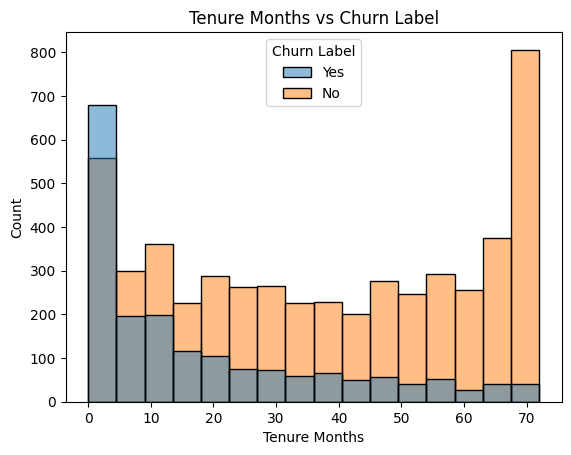

In [22]:
sns.histplot(data=df, x='Tenure Months', hue='Churn Label')
plt.title("Tenure Months vs Churn Label")
plt.show()

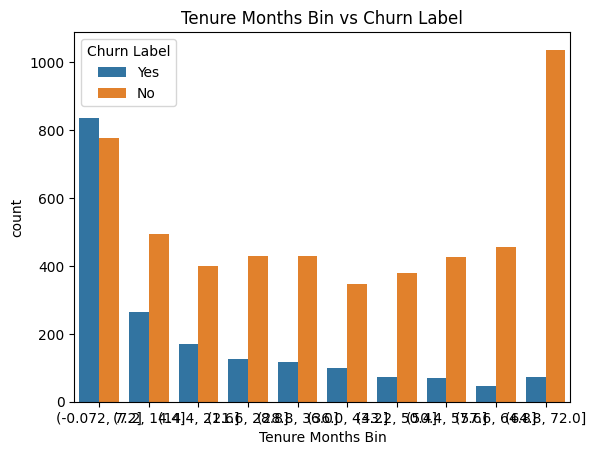

In [23]:
df['Tenure Months Bin'] = pd.cut(df['Tenure Months'], bins=10)
ax = sns.countplot(data=df, x='Tenure Months Bin', hue='Churn Label')
plt.title("Tenure Months Bin vs Churn Label")
plt.show()

User with low tenure has a high change of churning especially from 0 to 10 months tenure

## Monthly Purchase

In [24]:
df.pivot_table(index="Churn", values="Monthly Purchase (Thou. IDR)", aggfunc="mean")

,Monthly Purchase (Thou. IDR)
Churn,
0,79.644661
1,96.773732


Users churn because of monthly payment that they have to spend is more than the un-churned. But does it make sense. Let's take a look at the distribution

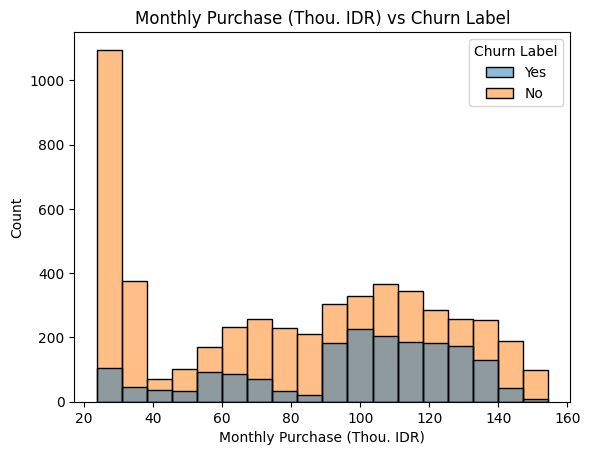

In [25]:
sns.histplot(data=df, x="Monthly Purchase (Thou. IDR)", hue="Churn Label")
plt.title("Monthly Purchase (Thou. IDR) vs Churn Label")
plt.show()

Customer also churned for low monhtly purchases, but mose of the churned users spend between Rp 100,000.00 - Rp 120,000.00 a month.

## CLTV

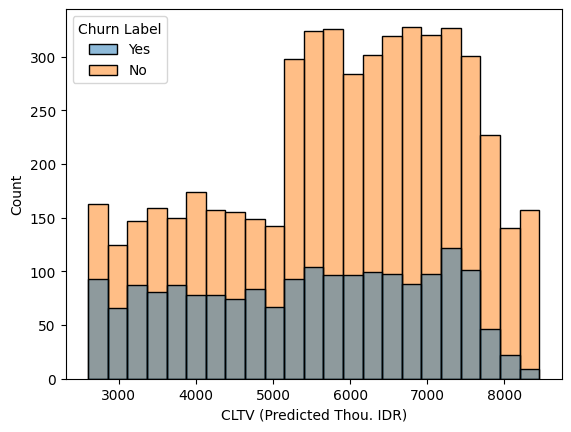

In [26]:
sns.histplot(data=df, x='CLTV (Predicted Thou. IDR)', hue='Churn Label')
plt.show()
plt.show()

CLTV can't be used as a feature because CLTV are normally distributed for all churned users, hence it is not a strong feature. The CLTV above Rp 7,500,000 has a high chance of churning.

## Call Center
Check whether the customer uses the call center service

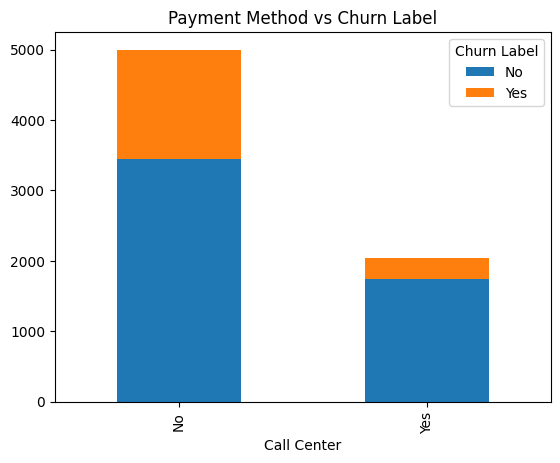

In [27]:
plot_df = df.pivot_table(index="Call Center", columns="Churn Label", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
plt.title("Payment Method vs Churn Label")
plt.show()

## Total Purchase

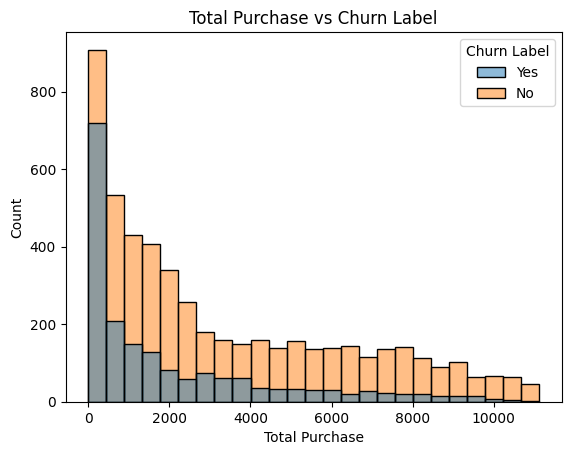

In [28]:
sns.histplot(data=df, x="Total Purchase", hue="Churn Label")
plt.title("Total Purchase vs Churn Label")
plt.show()

Really hard to tell based on the Total 

In [29]:
df

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR),Internet Service,Churn,Total Purchase,Tenure Months Bin
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7,1,1,140.01,"(-0.072, 7.2]"
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3,1,1,183.82,"(-0.072, 7.2]"
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6,1,1,1036.36,"(7.2, 14.4]"
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9,1,1,3814.72,"(21.6, 28.8]"
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0,1,1,6605.69,"(43.2, 50.4]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,72,Jakarta,Low End,No internet service,No internet service,No internet service,No,No internet service,No internet service,Debit,27.495,No,106.816666,-6.2,6897.8,0,0,1979.64,"(64.8, 72.0]"
7039,7039,24,Jakarta,Mid End,Yes,No,Yes,Yes,Yes,Yes,Digital Wallet,110.240,No,106.816666,-6.2,2782.0,1,0,2645.76,"(21.6, 28.8]"
7040,7040,72,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Credit,134.160,No,106.816666,-6.2,7228.0,1,0,9659.52,"(64.8, 72.0]"
7041,7041,11,Jakarta,Mid End,Yes,No,No,No,No,No,Pulsa,38.480,No,106.816666,-6.2,3630.9,1,0,423.28,"(7.2, 14.4]"


## Used Products

<function matplotlib.pyplot.show(close=None, block=None)>

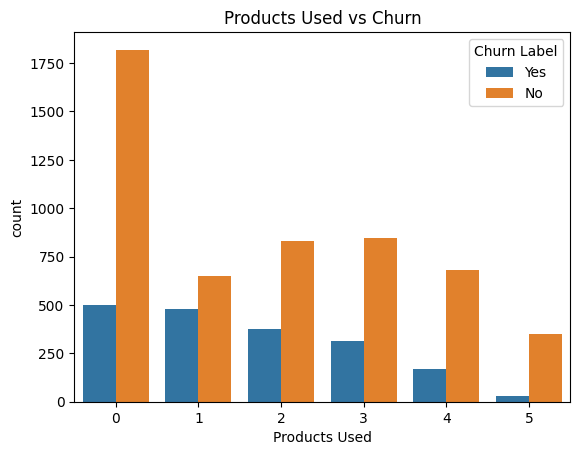

In [30]:
def uses_internet_for_product(data):
    if data == "Yes": 
        return 1
    return 0

# Total Product Used
df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp']]\
    .apply(lambda x: uses_internet_for_product(x['Games Product'])
        + uses_internet_for_product(x['Music Product'])
        + uses_internet_for_product(x['Education Product'])
        + uses_internet_for_product(x['Video Product'])
        + uses_internet_for_product(x['Use MyApp']), axis=1)

sns.countplot(data=df, x="Products Used", hue="Churn Label")
plt.title("Products Used vs Churn")
plt.show
# df

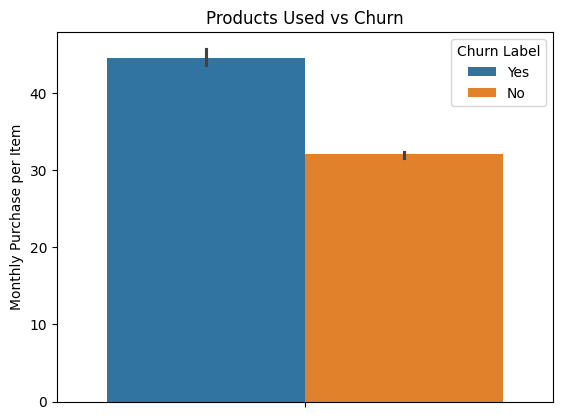

In [31]:
df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)

sns.barplot(data=df, y="Monthly Purchase per Item", hue="Churn Label")
plt.title("Products Used vs Churn")
plt.show()

User that pay more and use little of the product services has a high chance of churning

## Correlation Map

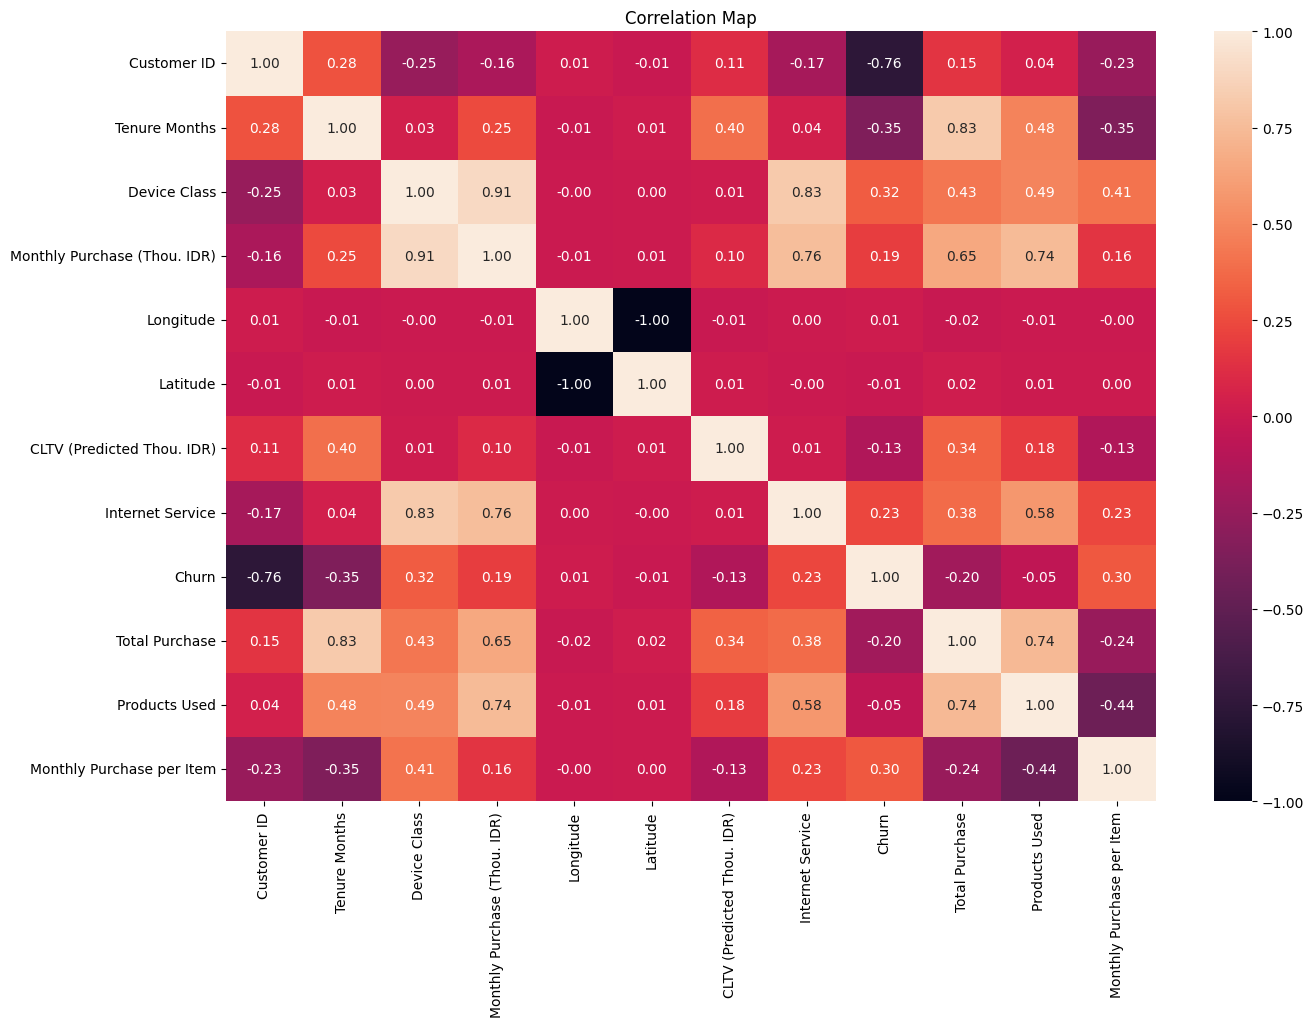

In [32]:
device_class_map = {
    "High End": 3,
    "Mid End": 2,
    "Low End": 1
}
df["Device Class"] = df["Device Class"].replace(device_class_map)
corr = df.select_dtypes([int, float]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Map")
plt.show()

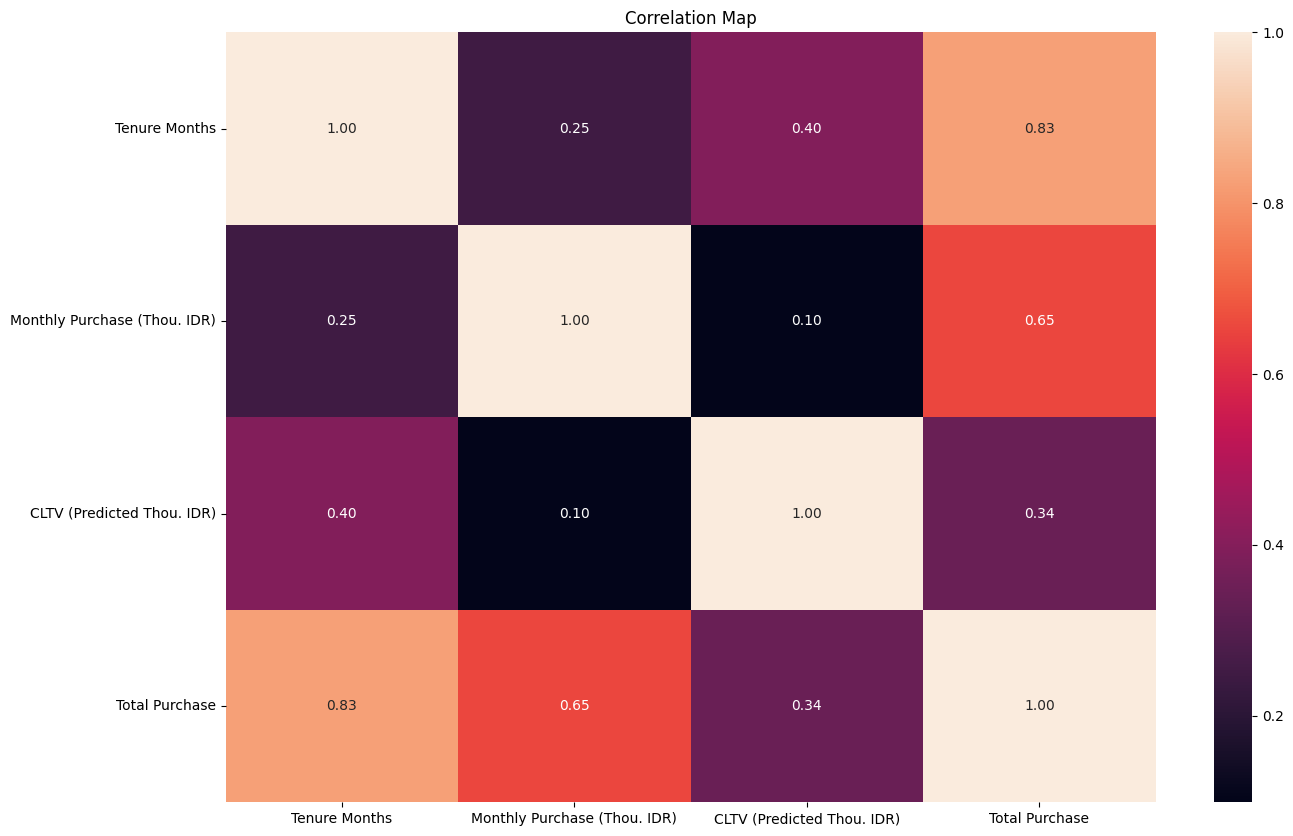

In [33]:
corr = df[["Tenure Months", "Monthly Purchase (Thou. IDR)", "CLTV (Predicted Thou. IDR)", "Total Purchase"]].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Map")
plt.show()

# Modelling

In [42]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve, accuracy_score
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

In [68]:
def evaluate(model, y_true, y_pred, y_pred_proba):
    """
        Evaluate model performance
    """
    print(f"""
    METRICS
    Accuracy: {accuracy_score(y_true, y_pred)}
    Precision: {precision_score(y_true, y_pred)}
    Recall: {recall_score(y_true, y_pred)}
    F1 Score: {f1_score(y_true, y_pred)}
    ROC AUC score: {roc_auc_score(y_true, y_pred)}
    Specificity: {specificity_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title("Confusion Matrix of Logistic Regression (aka. Baseline Model)")
    plt.show()

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()

    # swarmplot
    sns.swarmplot(x=y_pred_proba[:, 1], hue=y_true.tolist())
    plt.axvline(0.5, label="Threshold", color="red", linestyle="--")
    plt.xticks(np.arange(0, 1.001, 0.1))
    plt.show()

## Baseline Model AKA. Dummy Classifier


    METRICS
    Accuracy: 0.5990063875088716
    Precision: 0.24396782841823056
    Recall: 0.24331550802139038
    F1 Score: 0.2436412315930388
    ROC AUC score: 0.48542586995272413
    Specificity: 0.7275362318840579
    


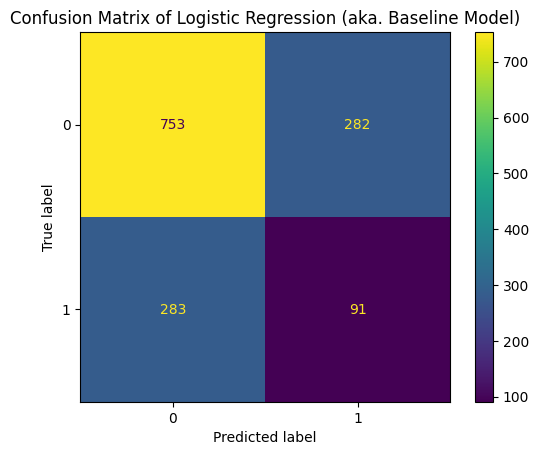

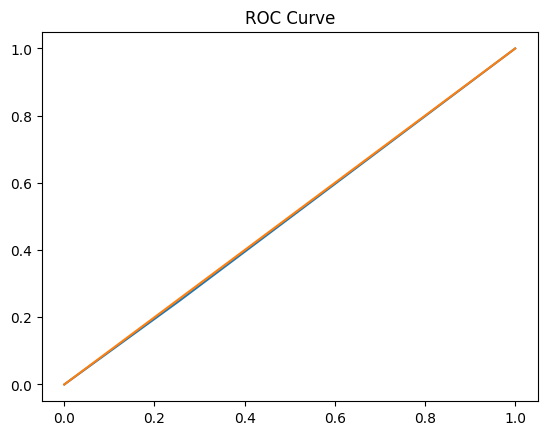

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 48.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 94.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


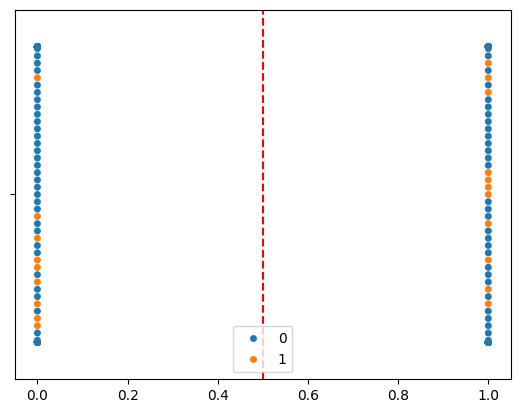

In [63]:
from sklearn.dummy import DummyClassifier
# Data Preparation
# ==============================================
df = df_ori.copy()
df = df.drop(columns=["Customer ID"])  # drop unimportant data
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label

X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Train Dummy Classifier
# ==============================================
model = DummyClassifier(strategy="stratified")
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

## Model Improvement

### Using Different Model

[0.51170569 0.55518395 0.51505017 0.55183946 0.4916388  0.51839465
 0.55183946 0.51505017 0.51505017 0.53511706] 
Score Mean: 0.5260869565217391

    METRICS
    Accuracy: 0.7899219304471257
    Precision: 0.6308724832214765
    Recall: 0.5026737967914439
    F1 Score: 0.5595238095238095
    ROC AUC score: 0.6981968017773644
    Specificity: 0.893719806763285
    


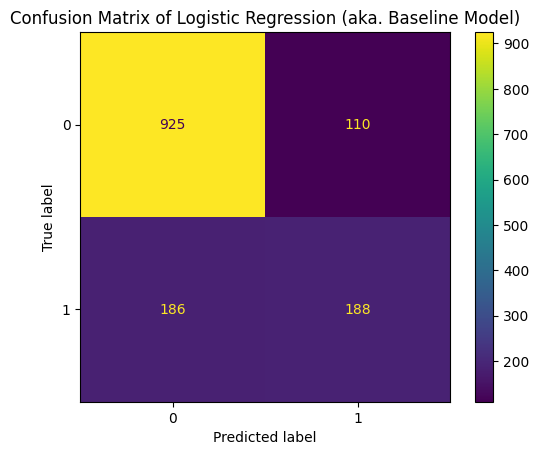

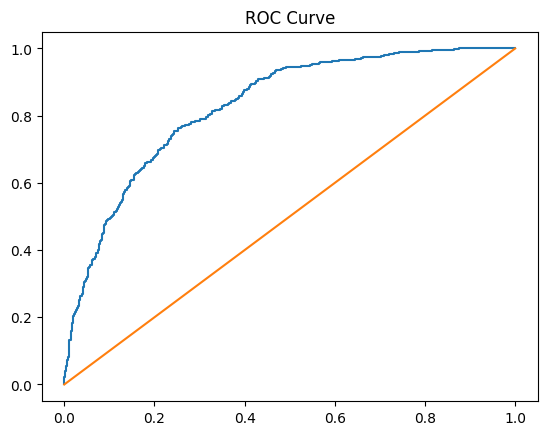

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 16.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


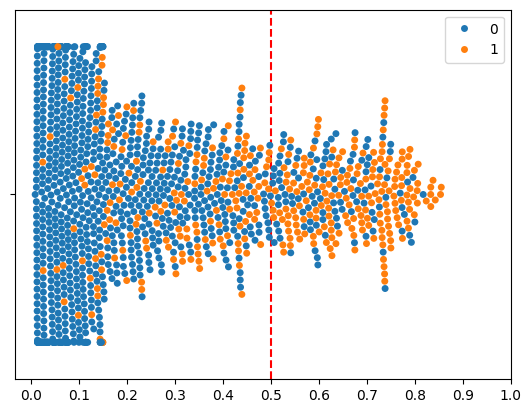

In [69]:
from sklearn.linear_model import LogisticRegression
# Data Preparation
# ==============================================
df = df_ori.copy()
df = df.drop(columns=["Customer ID"])  # drop unimportant data
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label

X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=500)  # <<<<<<<<<<<<< DIFFERENT MODEL
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
print(score, f"\nScore Mean: {score.mean()}")


# Train Dummy Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

1. We improve the specificity rate of predicting the negative class from **ground truth negative class**.
2. However we need to improve more on the recall and precision.

### Scaling Data

[0.50167224 0.5451505  0.51505017 0.56521739 0.48160535 0.5083612
 0.56187291 0.48829431 0.49498328 0.51839465] 
Score Mean: 0.5180602006688964

    METRICS
    Accuracy: 0.794180269694819
    Precision: 0.6428571428571429
    Recall: 0.5053475935828877
    F1 Score: 0.565868263473054
    ROC AUC score: 0.7019491591102844
    Specificity: 0.8985507246376812
    


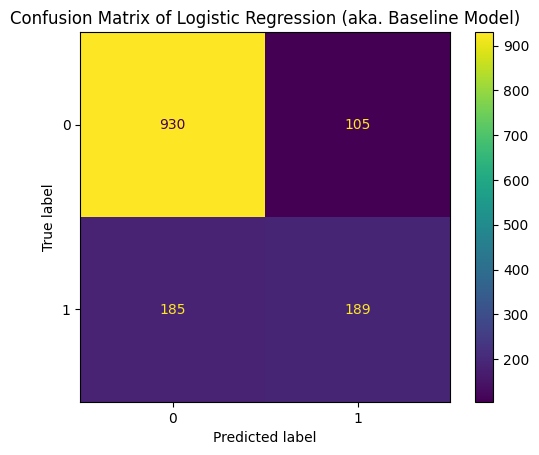

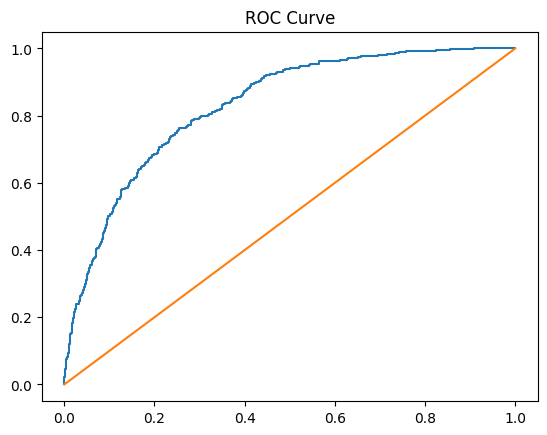

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 16.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


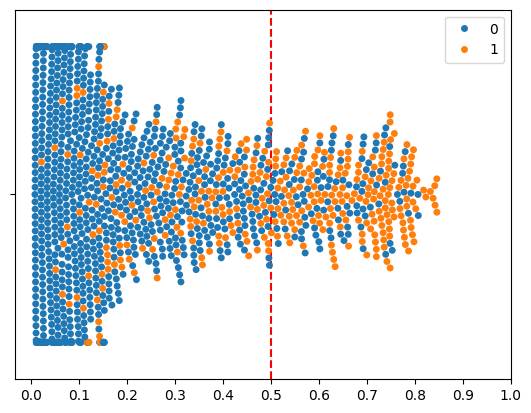

In [70]:
from sklearn.linear_model import LogisticRegression
# Data Preparation
# ==============================================
df = df_ori.copy()
df = df.drop(columns=["Customer ID"])  # drop unimportant data
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label

X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.fit_transform(X_test)  # <<<<<<<<<<<<< SCALING

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=500)  # <<<<<<<<<<<<< DIFFERENT MODEL
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
print(score, f"\nScore Mean: {score.mean()}")


# Train Dummy Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

Model improve just a little

### Feature Engineering

In [78]:
# function for feature engineering
def check_internet_service(row): 
    if row['Games Product'] == "No internet service"\
        and row['Music Product'] == "No internet service"\
        and row['Education Product'] == "No internet service"\
        and row['Video Product'] == "No internet service"\
        and row['Use MyApp'] == "No internet service":
        return 0
    else: return 1

def uses_internet_for_product(data):
    if data == "Yes": return 1
    return 0

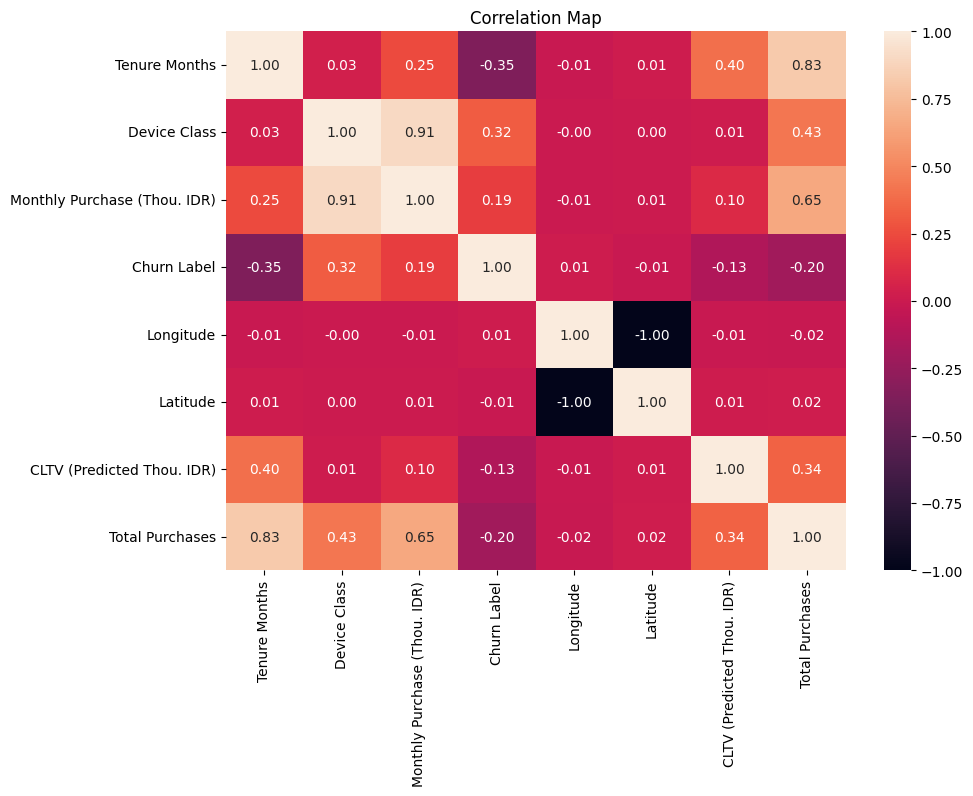

In [98]:
from sklearn.linear_model import LogisticRegression
# Data Preparation
# ==============================================
df = df_ori.copy()

# drop unimportant data
df = df.drop(columns=["Customer ID"])

# feature engineering
df['Total Purchases'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label


corr = df.select_dtypes([int, float]).corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Map")
plt.show()


Exist some multicllinearity between Total Purchases with CLTV, Tenure Months, Monthly Purchase and Device Classes. Let's try to perform PCA on it

In [109]:
from sklearn.decomposition import PCA
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X
# X_train_zscores = scaler.transform(X_train[['Tenure Months', 'Device Class', 'Monthly Purchase (Thou. IDR)', 'CLTV (Predicted Thou. IDR)','Total Purchases']])

In [103]:
df.columns

Index(['Tenure Months', 'Location', 'Device Class', 'Games Product',
       'Music Product', 'Education Product', 'Call Center', 'Video Product',
       'Use MyApp', 'Payment Method', 'Monthly Purchase (Thou. IDR)',
       'Churn Label', 'Longitude', 'Latitude', 'CLTV (Predicted Thou. IDR)',
       'Total Purchases'],
      dtype='object')

In [96]:
# X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# # Scale data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
# X_test = scaler.fit_transform(X_test)  # <<<<<<<<<<<<< SCALING

# # Cross Validation
# # ========================================
# model = LogisticRegression(random_state=42, max_iter=500)  # <<<<<<<<<<<<< DIFFERENT MODEL
# cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
# score = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
# print(score, f"\nScore Mean: {score.mean()}")


# # Train Dummy Classifier
# # ==============================================
# model = LogisticRegression(random_state=42, max_iter=500)
# model.fit(X_train, y_train)

# # Predict using Dummy Classifier
# # ==============================================
# y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)

# # Evaluate Model
# # ==============================================
# evaluate(model, y_test, y_pred, y_pred_proba)

#### Cross Validation


In [39]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
# Cross Validation
# ========================================

# prepare data
# ========================================
(X_train, X_test, y_train, y_test) = data_preparation_feature_selection(df_ori)

# create pipeline
# ========================================
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=200))

# perform cross validation
# ========================================
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall')
display(score, f"Score Mean: {score.mean()}")

array([0.50167224, 0.5451505 , 0.51170569, 0.56856187, 0.48494983,
       0.51170569, 0.55852843, 0.48829431, 0.4916388 , 0.51839465])

'Score Mean: 0.5180602006688965'

#### Model


        METRICS
        Precision: 0.6397306397306397
        Recall: 0.5080213903743316
        F1 Score: 0.5663189269746647
    


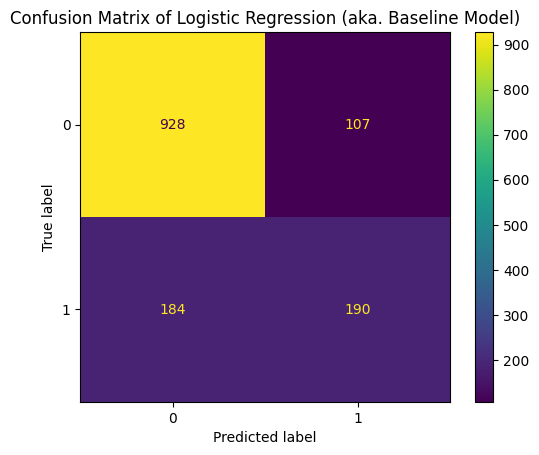

ROC AUC score: 0.7023198739311272


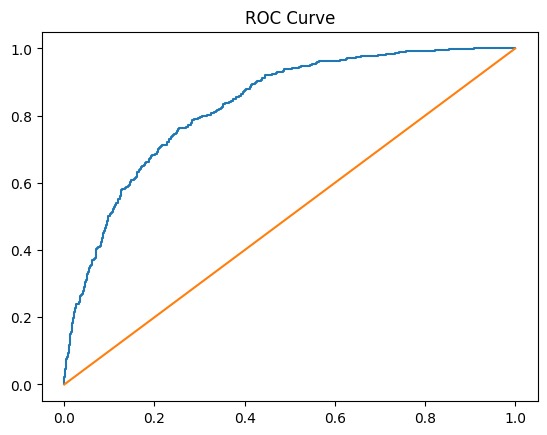

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


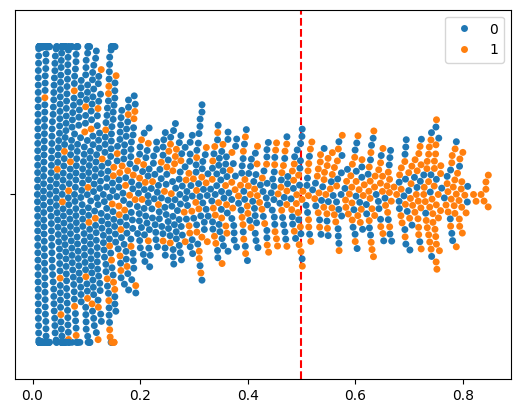

In [40]:
# prepare data
# ========================================
(X_train, X_test, y_train, y_test) = data_preparation_feature_selection(df_ori)

# scaling
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
baseline_model(X_train, y_train, scaler.transform(X_test), y_test)

### 1. Feature Engineering

In [ ]:
# Functions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression

def data_preparation_feature_engineering(data):
    """
        Prepare data
    """
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1

    def uses_internet_for_product(data):
        if data == "Yes": return 1
        return 0
    
    # get data
    df = data.copy()

    # drop unimportant data
    df = df.drop(columns=["Customer ID", "Longitude", "Latitude", "Location"])


    # feature engineering
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    df['Total Purchases'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp']]\
        .apply(lambda x: uses_internet_for_product(x['Games Product'])
            + uses_internet_for_product(x['Music Product'])
            + uses_internet_for_product(x['Education Product'])
            + uses_internet_for_product(x['Video Product'])
            + uses_internet_for_product(x['Use MyApp']), axis=1)
    df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)

    
    # encoding
    device_class_map = {
        "High End": 3,
        "Mid End": 2,
        "Low End": 1
    }
    df["Device Class"] = df["Device Class"].replace(device_class_map)
    df["Churn Label"] = df["Churn Label"].replace({"Yes": "1", "No": "0"}).astype(int)
    
    
    # split data to train and test
    X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
    X = pd.get_dummies(X, dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

    return (X_train, X_test, y_train, y_test)

# calculate precision, recall, f1 score
def evaluate(model, y_true, y_pred, y_pred_proba):
    """
        Evaluate model
    """
    print(f"""
        METRICS
        Precision: {precision_score(y_true, y_pred)}
        Recall: {recall_score(y_true, y_pred)}
        F1 Score: {f1_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title("Confusion Matrix of Logistic Regression (aka. Baseline Model)")
    plt.show()

    # ROC AUC score
    print(f"ROC AUC score: {roc_auc_score(y_true, y_pred)}")

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()
    

def baseline_model(X_train, y_train, X_val, y_val):
    """
       Perform baseline model training and evaluate result 
    """
    model = LogisticRegression(random_state=42, max_iter=200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    evaluate(model, y_val, y_pred, y_pred_proba)

    sns.swarmplot(x=y_pred_proba[:, 1], hue=y_val.tolist())
    plt.axvline(0.5, label="Threshold", color="red", linestyle="--")
    plt.show()

#### Cross Validation


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
# Cross Validation
# ========================================

# prepare data
# ========================================
(X_train, X_test, y_train, y_test) = data_preparation_feature_engineering(df_ori)

# create pipeline
# ========================================
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=200))

# perform cross validation
# ========================================
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall')
display(score, f"Score Mean: {score.mean()}")

array([0.51170569, 0.54849498, 0.51170569, 0.55852843, 0.48829431,
       0.51505017, 0.55852843, 0.50501672, 0.50167224, 0.52173913])

'Score Mean: 0.5220735785953177'

#### Baseline Model


        METRICS
        Precision: 0.636963696369637
        Recall: 0.516042780748663
        F1 Score: 0.5701624815361891
    


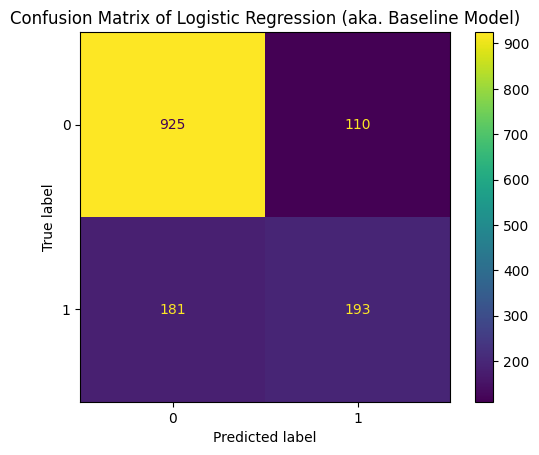

ROC AUC score: 0.7048812937559741


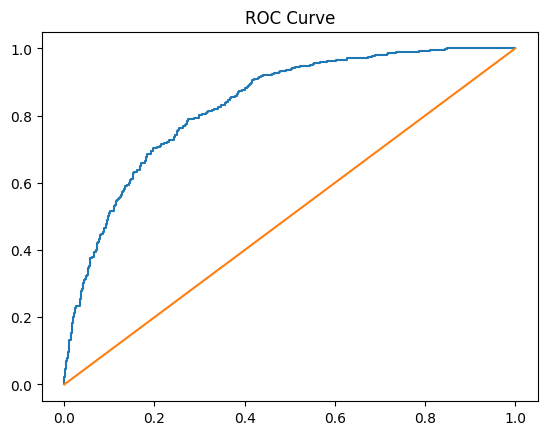

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 12.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


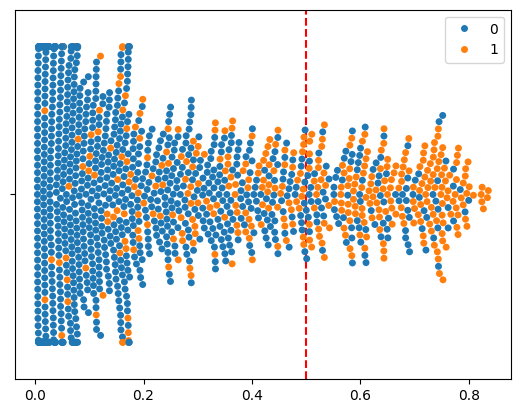

In [ ]:
# prepare data
# ========================================
(X_train, X_test, y_train, y_test) = data_preparation_feature_engineering(df_ori)

# scaling
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
baseline_model(X_train, y_train, scaler.transform(X_test), y_test)

### 2. Perform Oversampling
Oversampling is used to tackle imbalance class problem

In [ ]:
# Functions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression

def data_preparation_feature_engineering_smote(data):
    """
        Prepare data
    """
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1

    def uses_internet_for_product(data):
        if data == "Yes": return 1
        return 0
    
    # get data
    df = data.copy()

    # drop unimportant data
    df = df.drop(columns=["Customer ID", "Longitude", "Latitude", "Location"])

    # feature engineering
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    df['Total Purchases'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp']]\
        .apply(lambda x: uses_internet_for_product(x['Games Product'])
            + uses_internet_for_product(x['Music Product'])
            + uses_internet_for_product(x['Education Product'])
            + uses_internet_for_product(x['Video Product'])
            + uses_internet_for_product(x['Use MyApp']), axis=1)
    df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)
    
    # encoding
    device_class_map = {
        "High End": 3,
        "Mid End": 2,
        "Low End": 1
    }
    df["Device Class"] = df["Device Class"].replace(device_class_map)
    df["Churn Label"] = df["Churn Label"].replace({"Yes": "1", "No": "0"}).astype(int)
    
    # split data to train and test
    X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
    X = pd.get_dummies(X, dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

    # Oversample train data
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    return (X_train, X_test, y_train, y_test)

# calculate precision, recall, f1 score
def evaluate(model, y_true, y_pred, y_pred_proba):
    """
        Evaluate model
    """
    print(f"""
        METRICS
        Precision: {precision_score(y_true, y_pred)}
        Recall: {recall_score(y_true, y_pred)}
        F1 Score: {f1_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title("Confusion Matrix of Logistic Regression (aka. Baseline Model)")
    plt.show()

    # ROC AUC score
    print(f"ROC AUC score: {roc_auc_score(y_true, y_pred)}")

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()
    

def baseline_model(X_train, y_train, X_val, y_val):
    """
       Perform baseline model training and evaluate result 
    """
    model = LogisticRegression(random_state=42, max_iter=200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    evaluate(model, y_val, y_pred, y_pred_proba)

    sns.swarmplot(x=y_pred_proba[:, 1], hue=y_val.tolist())
    plt.axvline(0.5, label="Threshold", color="red", linestyle="--")
    plt.show()

#### Cross Validation


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
# Cross Validation
# ========================================

# prepare data
# ========================================
(X_train, X_test, y_train, y_test) = data_preparation_feature_engineering_smote(df_ori)

# create pipeline
# ========================================
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=200))

# perform cross validation
# ========================================
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall')
display(score, f"Score Mean: {score.mean()}")

NameError: name 'df_ori' is not defined

#### Baseline Model


        METRICS
        Precision: 0.43768545994065283
        Recall: 0.7887700534759359
        F1 Score: 0.5629770992366412
    


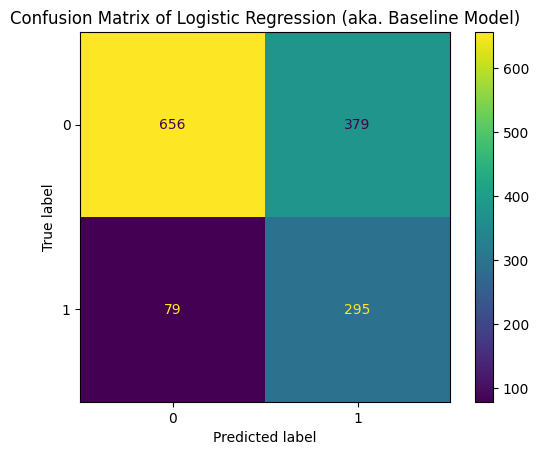

ROC AUC score: 0.7112932392983544


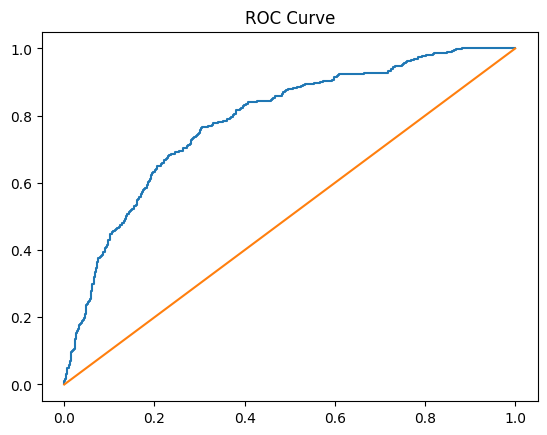

KeyboardInterrupt: 

In [ ]:
# prepare data
# ========================================
(X_train, X_test, y_train, y_test) = data_preparation_feature_engineering_smote(df_ori)
# X_val, X_test, y_val, y_test = train_test_split(
#     X_val, y_val, 
#     test_size=0.5, 
#     shuffle=True, 
#     stratify=y_val, 
#     random_state=42
# )

# scaling
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

baseline_model(X_train, y_train, scaler.transform(X_test), y_test)

### 3. Try Other Models

In [ ]:
# # classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, precision_score, f1_score

models = [
    LogisticRegression(random_state=42, max_iter=200), SVC(probability=True), KNeighborsClassifier(), GaussianNB(),
    DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42), 
    AdaBoostClassifier(random_state=42), GradientBoostingClassifier(random_state=42), XGBClassifier(random_state=42),
    CatBoostClassifier(random_state=42), LGBMClassifier(objective='binary', random_state=42), ExtraTreesClassifier(random_state=42)
]

recalls = []
precisions = []
f1s = []
roc_aucs = []
threshold=0.5

for model in models:
    # get data
    (X_train, X_test, y_train, y_test) = data_preparation_feature_engineering_smote(df_ori)
    
    # standardize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    # train
    model.fit(X_train, y_train)

    # predict
    y_pred_proba = model.predict_proba(scaler.transform(X_test))
    y_pred = [1 if proba > threshold else 0 for proba in y_pred_proba[:, 1]]
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred))
    
df_model = pd.DataFrame(
    {
        "Model Name": [model.__class__.__name__ for model in models],
        "Threshold": [threshold for _ in range(len(models))],
        "Recall": recalls,
        "Precisions": precisions,
        "F1 Score": f1s,
        "ROC AUC Score": roc_aucs,
    }
)

df_model

Learning rate set to 0.025403
0:	learn: 0.6751776	total: 3.48ms	remaining: 3.47s
1:	learn: 0.6580695	total: 6.63ms	remaining: 3.31s
2:	learn: 0.6403398	total: 10.5ms	remaining: 3.5s
3:	learn: 0.6243445	total: 13.8ms	remaining: 3.43s
4:	learn: 0.6138849	total: 16.9ms	remaining: 3.37s
5:	learn: 0.5996291	total: 20ms	remaining: 3.31s
6:	learn: 0.5868021	total: 23.2ms	remaining: 3.29s
7:	learn: 0.5779855	total: 26.9ms	remaining: 3.34s
8:	learn: 0.5639834	total: 30ms	remaining: 3.31s
9:	learn: 0.5536667	total: 33.1ms	remaining: 3.28s
10:	learn: 0.5461780	total: 36.2ms	remaining: 3.25s
11:	learn: 0.5317833	total: 39.4ms	remaining: 3.24s
12:	learn: 0.5239992	total: 43.8ms	remaining: 3.32s
13:	learn: 0.5173642	total: 46.9ms	remaining: 3.3s
14:	learn: 0.5107274	total: 50ms	remaining: 3.29s
15:	learn: 0.5064091	total: 53.3ms	remaining: 3.27s
16:	learn: 0.5003119	total: 56.8ms	remaining: 3.29s
17:	learn: 0.4891026	total: 60.2ms	remaining: 3.28s
18:	learn: 0.4789402	total: 63.4ms	remaining: 3.27s


,Model Name,Threshold,Recall,Precisions,F1 Score,ROC AUC Score
0,LogisticRegression,0.5,0.556150,0.630303,0.590909,0.719138
1,SVC,0.5,0.518717,0.625806,0.567251,0.703320
2,KNeighborsClassifier,0.5,0.497326,0.545455,0.520280,0.673784
3,GaussianNB,0.5,0.788770,0.437685,0.562977,0.711293
4,DecisionTreeClassifier,0.5,0.481283,0.459184,0.469974,0.638226
5,RandomForestClassifier,0.5,0.540107,0.592375,0.565035,0.702904
6,AdaBoostClassifier,0.5,0.612299,0.547847,0.578283,0.714845
7,GradientBoostingClassifier,0.5,0.601604,0.589005,0.595238,0.724957
8,XGBClassifier,0.5,0.518717,0.586103,0.550355,0.693175
9,CatBoostClassifier,0.5,0.540107,0.602985,0.569817,0.705802


# LGBM Classifier (Best Model) Hyperparameter Tuning

In [ ]:
def data_preparation_hp_lbgm(data):
    """
        Prepare data
    """
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1

    def uses_internet_for_product(data):
        if data == "Yes": return 1
        return 0
    
    # get data
    df = data.copy()

    # drop unimportant data
    df = df.drop(columns=["Customer ID", "Latitude", "Longitude"])

    # feature engineering
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    df['Total Purchases'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp']]\
        .apply(lambda x: uses_internet_for_product(x['Games Product'])
            + uses_internet_for_product(x['Music Product'])
            + uses_internet_for_product(x['Education Product'])
            + uses_internet_for_product(x['Call Center'])
            + uses_internet_for_product(x['Use MyApp']), axis=1)
    df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)
    
    # encoding
    device_class_map = {
        "High End": 3,
        "Mid End": 2,
        "Low End": 1
    }
    df["Device Class"] = df["Device Class"].replace(device_class_map)
    df["Churn Label"] = df["Churn Label"].replace({"Yes": "1", "No": "0"}).astype(int)
    
    # split data to train and test
    X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
    X = pd.get_dummies(X, dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train, shuffle=True)

    # Oversample train data
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [ ]:

# prepare data
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation_hp_lbgm(df_ori)

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'num_iterations': [], # number of trees
        'learning_rate', # learning rate of model [0.001, 0.1]
        'num_leaves', # max number of leave nodes (decisions) [2, .., 1024]
        'subsample', # amount of data will be used in each iteration of building tree
        'bagging_freq', # frequency of resampling the data in each iteration of building the tree
        'colsample_bytree', # proportion of features used in tree building
        'min_data_in_leaf', # minimal leave nodes inside the lgbm model
    }


NameError: name 'params' is not defined